# Exploratory Data Analysis 

In [236]:
# Importar las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import ceil
from matplotlib.colors import LinearSegmentedColormap

In [237]:
def df_overview(df: pd.DataFrame, round_ndigits: int = 4) -> pd.DataFrame:
    """
    Resumen general del DataFrame:
    - Dimensiones, memoria total y tipos de columnas
    - Celdas nulas y porcentaje
    - Estadísticos globales del .describe()
    Retorna un DataFrame con una fila y el describe transpuesto.
    """
    n_rows, n_cols = df.shape
    total_mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
    null_cells = df.isna().sum().sum()
    pct_null_cells = (null_cells / (n_rows * n_cols) * 100.0) if n_rows and n_cols else 0.0

    summary_data = {
    "n_rows": n_rows,
    "n_cols": n_cols,
    "total_memory_mb": round(total_mem_mb, 6),
    "total_null_cells": int(null_cells),
    "%null_cells": round(pct_null_cells, round_ndigits),
    "n_numeric_cols": int(sum(pd.api.types.is_numeric_dtype(df[c]) for c in df.columns)),
    "n_category_cols": int(sum(pd.api.types.is_categorical_dtype(df[c]) for c in df.columns)),
    "n_datetime_cols": int(sum(pd.api.types.is_datetime64_any_dtype(df[c]) for c in df.columns)),
    }
    
    overview_df = pd.DataFrame([summary_data])
    
    return overview_df

In [238]:
def df_report(
    df: pd.DataFrame,
    round_ndigits: int = 4,
) -> pd.DataFrame:
    """
    Genera un reporte compacto por columna.

    Campos del DataFrame de salida:
      - column: nombre de la columna.
      - dtype: tipo de dato en pandas (p. ej., int64, float64, object, category, datetime64[ns]).
      - memory_mb: memoria estimada usada por la columna (MB).
      - n_rows: número total de filas del DataFrame.
      - non_null: número de valores no nulos en la columna.
      - nulls: número de valores nulos en la columna.
      - %nulls: porcentaje de valores nulos respecto a n_rows.
      - unique: número de valores distintos (excluye NaN).
      - %unique_on_non_null: porcentaje de valores distintos sobre los no nulos.
      - is_constant: True si la columna tiene un único valor (y al menos un no nulo).

    Parámetros:
      - df: DataFrame a perfilar.
      - round_ndigits: decimales para redondear porcentajes/memoria.

    Retorna:
      - DataFrame con una fila por columna y las métricas anteriores.
    """
    n_rows = len(df)
    mem_per_col = df.memory_usage(deep=True)  # bytes por columna

    rows = []
    for col in df.columns:
        s = df[col]
        dtype = s.dtype
        non_null = int(s.notna().sum())
        nulls = int(n_rows - non_null)
        pct_null = (nulls / n_rows * 100.0) if n_rows else 0.0
        nunique = int(s.nunique(dropna=True))
        unique_ratio = (nunique / non_null * 100.0) if non_null else 0.0
        mem_mb = float(mem_per_col.get(col, 0)) / (1024 ** 2)

        rows.append({
            "column": col,
            "dtype": str(dtype),
            "memory_mb": round(mem_mb, 6),
            "n_rows": n_rows,
            "non_null": non_null,
            "nulls": nulls,
            "%nulls": round(pct_null, round_ndigits),
            "unique": nunique,
            "%unique_on_non_null": round(unique_ratio, round_ndigits),
            "is_constant": bool(nunique == 1 and non_null > 0),
        })

    report = pd.DataFrame(rows)[[
        "column", "dtype", "memory_mb",
        "n_rows", "non_null", "nulls", "%nulls",
        "unique", "%unique_on_non_null",
        "is_constant",
    ]]

    return report

In [239]:
def summary_with_moments(df: pd.DataFrame, columns, round_ndigits: int = 4) -> pd.DataFrame:
    """
    Create a stats table for selected columns including describe + median, kurt, skew.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    columns : list[str]
        Columns to summarize.
    round_ndigits : int, default 4
        Round the output.

    Returns
    -------
    pd.DataFrame
        Rows = statistics, Columns = variables.
    """
    cols = [c for c in columns if c in df.columns]
    if not cols:
        raise ValueError("None of the provided columns exist in the DataFrame.")

    # Build stats per column using numeric coercion (non-numeric -> NaN)
    table = {}
    for col in cols:
        s = pd.to_numeric(df[col], errors="coerce")
        stats = {
            "count": s.count(),
            "mean": s.mean(),
            "std": s.std(ddof=1),
            "min": s.min(),
            "25%": s.quantile(0.25),
            "50%": s.quantile(0.50),   # same as median from describe
            "median": s.median(),      # explicit median as requested
            "75%": s.quantile(0.75),
            "max": s.max(),
            "skew": s.skew(),
            "kurt": s.kurtosis(),      # alias: s.kurt()
        }
        table[col] = stats

    out = pd.DataFrame(table)
    return out.round(round_ndigits)

In [240]:
def classify_distributions(
    stats_df: pd.DataFrame,
    skew_col: str = "skew",
    kurt_col: str = "kurt",     # excess kurtosis expected here (Pandas .kurtosis())
    count_col: str = "count",
    skew_bins=(0.5, 1.0),       # |skew| < 0.5 ~ symmetric; [0.5,1) moderate; >=1 high
    kurt_bins=(0.5, 2.0),       # |excess kurtosis| < 0.5 ~ mesokurtic; [0.5,2) moderate; >=2 high
    z_threshold: float = 2.0    # significance cutoff for Z-tests
) -> pd.DataFrame:
    """
    Classify variables by skewness and excess kurtosis.

    Parameters
    ----------
    stats_df : pd.DataFrame
        Table with at least columns [count, skew, kurt] and index = variable names.
    skew_col, kurt_col, count_col : str
        Column names in stats_df for skewness, excess kurtosis, and sample size.
    skew_bins : (float, float)
        Thresholds for |skew| to label magnitude: (near_zero, moderate_high).
    kurt_bins : (float, float)
        Thresholds for |excess kurtosis|: (near_zero, very_heavy/light).
    z_threshold : float
        |Z| above this value → “statistically different from 0”.

    Returns
    -------
    pd.DataFrame
        One row per variable with labels for skew, tails, overall shape, and Z-test flags.
    """
    df = stats_df.copy()

    # --- Helpers --------------------------------------------------------------
    def label_skew(s):
        a = abs(s)
        if a < skew_bins[0]:
            base = "symmetric"
        elif a < skew_bins[1]:
            base = "moderately right-skewed" if s > 0 else "moderately left-skewed"
        else:
            base = "highly right-skewed" if s > 0 else "highly left-skewed"
        return base

    def label_kurt(k):
        # k is EXCESS kurtosis
        a = abs(k)
        if a < kurt_bins[0]:
            return "mesokurtic (normal-like tails)"
        if k > 0:
            return "leptokurtic (heavy tails)" if a < kurt_bins[1] else "very leptokurtic (very heavy tails)"
        else:
            return "platykurtic (light tails)" if a < kurt_bins[1] else "very platykurtic (very light tails)"

    def overall_shape(skew, kurt):
        # concise grid label
        s = "right-skewed" if skew > skew_bins[0] else "left-skewed" if skew < -skew_bins[0] else "symmetric"
        if abs(kurt) < kurt_bins[0]:
            t = "normal-like tails"
        else:
            t = "heavy tails" if kurt > 0 else "light tails"
        return f"{s}, {t}"

    # --- Z-tests for “different from 0” (rough, large-sample) ----------------
    # SE(skew) ≈ sqrt(6/n), SE(kurt_excess) ≈ sqrt(24/n)
    n = df[count_col].astype(float)
    se_skew = np.sqrt(6.0 / n)
    se_kurt = np.sqrt(24.0 / n)
    z_skew = df[skew_col] / se_skew
    z_kurt = df[kurt_col] / se_kurt

    # --- Build output ---------------------------------------------------------
    out = pd.DataFrame(index=stats_df.index)
    out["n"] = n
    out["skew"] = df[skew_col]
    out["kurtosis"] = df[kurt_col]
    out["skew_label"] = df[skew_col].apply(label_skew)
    out["kurtosis_label"] = df[kurt_col].apply(label_kurt)
    out["shape"] = [overall_shape(s, k) for s, k in zip(df[skew_col], df[kurt_col])]
    out["skew_Z"] = z_skew
    out["kurt_Z"] = z_kurt
    out["skew_significant"] = z_skew.abs() >= z_threshold
    out["kurt_significant"] = z_kurt.abs() >= z_threshold

    return out

In [241]:
def plot_histograms(df, columns, color="navy", bins=30, kde=False, height=3.2, aspect=1.6):
    """
    Plot one histogram per column using seaborn.

    Parameters
    ----------
    df : pandas.DataFrame
        Source data.
    columns : list[str]
        Columns to plot (numeric recommended).
    color : {'navy', 'black', 'white'}, default 'navy'
        Bar color. If 'white', a black edge is added for visibility.
    bins : int, default 30
        Number of histogram bins.
    kde : bool, default False
        Overlay KDE curve.
    height : float, default 3.2
        Height (inches) of each figure.
    aspect : float, default 1.6
        Width/height ratio of each figure.

    Returns
    -------
    list[matplotlib.axes.Axes]
        List of axes for further customization.
    """
    valid_colors = {"navy", "black", "white"}
    if color not in valid_colors:
        raise ValueError(f"'color' must be one of {valid_colors}")

    sns.set_theme(style="whitegrid")
    axes = []

    for col in columns:
        # Skip non-existent columns gracefully
        if col not in df.columns:
            print(f"[skip] '{col}' not in DataFrame.")
            continue

        # Prepare styling for 'white' bars so they don't disappear
        hist_kws = {}
        edgecolor = None
        linewidth = None
        if color == "white":
            edgecolor = "black"
            linewidth = 0.8
            hist_kws.update(dict(edgecolor=edgecolor, linewidth=linewidth))

        fig, ax = plt.subplots(figsize=(height*aspect, height))
        sns.histplot(
            data=df,
            x=col,
            bins=bins,
            kde=kde,
            color=color,
            **hist_kws
        )
        ax.set_title(f"Histogram: {col}", pad=10)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        axes.append(ax)

    return axes

In [242]:
def qq_plots(
    df: pd.DataFrame,
    columns,
    dist: str = "norm",      # theoretical distribution ('norm', 't', 'expon', etc.)
    sparams=None,            # optional params for the chosen distribution, e.g. (df,) for 't'
    ncols: int = 3,          # number of columns in the subplot grid
    height: float = 3.4,     # height (inches) per subplot
    color_line: str = "black",
    color_points: str = "navy"
):
    """
    Draw Q–Q plots for a list of DataFrame columns.

    Parameters
    ----------
    df : pd.DataFrame
        Source data.
    columns : list[str]
        Columns to plot.
    dist : str, default 'norm'
        Theoretical distribution name (as in scipy.stats).
    sparams : tuple | None
        Optional parameters for the theoretical distribution.
    ncols : int, default 3
        Number of columns in the subplot grid.
    height : float, default 3.4
        Height of each subplot (inches).
    color_line : str, default 'black'
        Color of the reference line.
    color_points : str, default 'navy'
        Color of sample points.

    Returns
    -------
    np.ndarray of matplotlib.axes.Axes
        Axes grid with the Q–Q plots.
    """
    cols = [c for c in columns if c in df.columns]
    if not cols:
        raise ValueError("None of the provided columns exist in the DataFrame.")

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * height * 1.25, nrows * height))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        if s.empty:
            ax.text(0.5, 0.5, f"{col}\n(no data)", ha="center", va="center")
            ax.axis("off")
            continue

        # Q–Q plot vs. theoretical quantiles
        (osm, osr), (slope, intercept, r) = stats.probplot(s, dist=dist, sparams=sparams, fit=True)
        ax.scatter(osm, osr, s=14, alpha=0.85, color=color_points)
        ax.plot(osm, slope * np.array(osm) + intercept, linewidth=1.4, color=color_line)

        # Quick stats
        skew = s.skew()
        kurt = s.kurtosis()  # excess kurtosis

        ax.set_title(f"{col} | skew={skew:.2f}, kurt={kurt:.2f}", pad=8)
        ax.set_xlabel("Theoretical quantiles")
        ax.set_ylabel("Sample quantiles")

    # Turn off spare axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    return axes.reshape(nrows, ncols)[:nrows, :ncols]

In [243]:
def boxplots(df: pd.DataFrame, columns=None, color: str = "navy", showfliers: bool = True):
    """
    Draw one boxplot per numeric column (or given columns) using only 'navy', 'black', or 'white'.
    """
    valid = {"navy", "black", "white"}
    if color not in valid:
        raise ValueError(f"color must be one of {valid}")

    sns.set_theme(style="whitegrid")

    # choose columns
    if columns is None:
        columns = df.select_dtypes(include="number").columns.tolist()
    else:
        columns = [c for c in columns if c in df.columns]

    # styling: keep 'white' visible with black edges
    edge = "black" if color == "white" else color
    boxprops     = dict(facecolor=color, edgecolor=edge)
    whiskerprops = dict(color=edge)
    capprops     = dict(color=edge)
    medianprops  = dict(color="black")
    flierprops   = dict(markerfacecolor=color, markeredgecolor=edge, markersize=4, alpha=0.7)

    for col in columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(
            data=df,
            y=col,
            color=color,
            showfliers=showfliers,
            boxprops=boxprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
            flierprops=flierprops
        )
        plt.title(f"Boxplot: {col}")
        plt.ylabel("Value")
        plt.xlabel("")
        plt.tight_layout()
        plt.show()

In [244]:
def simple_countplots(
    df: pd.DataFrame,
    columns=None,          # columnas categóricas a graficar; si None, toma object/category/bool
    hue: str | None = None,
    color: str = "navy",   # {'navy','black','white'}
    top_n: int | None = None,  # muestra sólo las top_n categorías más frecuentes
    rotate: int = 0,       # rotación de etiquetas del eje x
    show_pct: bool = False # además del count, anota porcentaje
):
    valid = {"navy", "black", "white"}
    if color not in valid:
        raise ValueError(f"color must be one of {valid}")

    sns.set_theme(style="whitegrid")

    # columnas por defecto: categóricas
    if columns is None:
        columns = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    else:
        columns = [c for c in columns if c in df.columns]

    # estilo cuando color es 'white'
    edge = "black" if color == "white" else color

    for col in columns:
        s = df[col].astype("category")

        # Top-N categorías (el resto se agrupa en 'Other')
        if top_n is not None and top_n > 0 and s.nunique() > top_n:
            top_vals = s.value_counts().nlargest(top_n).index
            s = s.where(s.isin(top_vals), other="Other").astype("category")

        # Orden por frecuencia
        order = s.value_counts().index

        # Plot
        plt.figure(figsize=(8, 4.6))
        ax = sns.countplot(
            x=s,
            order=order,
            hue=df[hue] if hue else None,
            palette=None if hue else None,   # un solo color cuando no hay hue
            color=color if not hue else None,
            edgecolor=edge if color == "white" else None
        )
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Countplot: {col}")
        plt.xticks(rotation=rotate)

        # Anotar conteos (y % opcional). Para hue, anota por barra apilada de cada nivel.
        total = len(s)
        for p in ax.patches:
            height = p.get_height()
            if height <= 0:
                continue
            x = p.get_x() + p.get_width() / 2
            y = height
            label = f"{int(height)}"
            if show_pct:
                pct = height / total * 100
                label += f"\n{pct:.1f}%"
            ax.annotate(label, (x, y), ha="center", va="bottom", fontsize=9, xytext=(0, 2), textcoords="offset points")

        plt.tight_layout()
        plt.show()

        # Tablita de conteos (y % si se pidió)
        vc = s.value_counts(dropna=False)
        out = pd.DataFrame({"count": vc, "percent": (vc / total * 100).round(2)})
        display(out)  # en notebooks; si no, usa print(out)

In [245]:
def correlation_heatmap(
    df: pd.DataFrame,
    columns=None,                 # columns to include (None -> all numeric)
    method: str = "pearson",      # 'pearson' | 'spearman' | 'kendall'
    figsize=(10, 6),
    annot: bool = True,
    fmt: str = ".2f",
    mask_upper: bool = True       # hides upper triangle for readability
) -> pd.DataFrame:
    """
    Compute and plot a correlation matrix for selected columns.

    Returns the correlation DataFrame.
    """
    # choose columns
    if columns is None:
        cols = df.select_dtypes(include="number").columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns]

    # coerce to numeric (non-numeric -> NaN) and drop all-NaN columns
    df_num = df[cols].apply(pd.to_numeric, errors="coerce")
    df_num = df_num.dropna(axis=1, how="all")

    corr = df_num.corr(method=method)

    # optional mask to show only lower triangle
    mask = None
    if mask_upper:
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        fmt=fmt,
        cmap="coolwarm",
        vmin=-1, vmax=1,
        linewidths=0.5,
        mask=mask
    )
    plt.title(f"Correlation Matrix ({method.title()})")
    plt.tight_layout()
    plt.show()

    return corr

In [246]:
def scatter_all_pairs(
    df: pd.DataFrame,
    cols: list[str] | None = None,
    hue: str | None = None,
    diag_kind: str = "hist",  # "hist" or "kde"
    height: float = 2.6,
    corner: bool = False,     # True = lower triangle only
    alpha: float = 0.7,
    s: int = 20,
):
    """
    Build a scatterplot matrix (all possible pairs) using seaborn.

    Args:
        df: Input pandas DataFrame.
        cols: Columns to include; if None, uses numeric columns.
        hue: Categorical column to color points (optional).
        diag_kind: "hist" or "kde" for the diagonal plots.
        height: Size (inches) of each facet cell.
        corner: If True, show only the lower triangle (faster for many columns).
        alpha: Point transparency.
        s: Point size.
    """
    if cols is None:
        cols = df.select_dtypes(include="number").columns.tolist()

    # Clean white theme
    sns.set_style("whitegrid")

    # Palette: navy & black. If no hue, force a single navy color.
    palette = ["navy", "black"]
    plot_kws = {"alpha": alpha, "s": s}
    if hue is None:
        plot_kws["color"] = "navy"

    g = sns.pairplot(
        df[cols].join(df[[hue]] if hue else df.iloc[:, 0:0]),
        vars=cols,
        hue=hue,
        diag_kind=diag_kind,
        corner=corner,
        height=height,
        plot_kws=plot_kws,
        palette=palette if hue else None,
    )
    g.fig.suptitle("Scatterplots of all pairs", y=1.02)
    plt.show()

In [247]:
def scatter_simple(df, x, y, hue=None):
    """
    Single (x, y) scatter plot.
    - If hue is None: all points navy.
    - If hue is set: palette = [navy, black].
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))

    if hue is None:
        ax = sns.scatterplot(data=df, x=x, y=y, color="navy", s=25, alpha=0.7)
    else:
        ax = sns.scatterplot(data=df, x=x, y=y, hue=hue,
                             palette=["navy", "black"], s=25, alpha=0.7)

    ax.set_title(f"{y} vs {x}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if hue:
        ax.legend(title=hue, frameon=True)
    plt.tight_layout()
    plt.show()

In [248]:
def barplots(
    df: pd.DataFrame,
    x_cols: list[str],
    y: str,
    estimator=None,
    hue: str | None = None,
    ncols: int = 2,
    height: float = 4.5,
    rotate: int = 0,
    order: dict[str, list] | None = None,
    show: bool = True,     # if True -> show & close; if False -> return fig
):
    assert y in df.columns, f"{y} not in DataFrame."
    n = len(x_cols)
    ncols = max(1, ncols)
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.5*ncols, height*nrows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    pal = _nbw_palette(len(df[hue].dropna().unique())) if hue else None
    color = "navy" if not hue else None

    for ax, x in zip(axes, x_cols):
        if x not in df.columns:
            ax.set_visible(False)
            continue

        x_order = (order or {}).get(x, None)
        kws = dict(data=df, x=x, y=y, hue=hue, order=x_order, palette=pal, color=color, ax=ax, edgecolor="black")
        try:
            sns.barplot(**kws, estimator=estimator, errorbar=None)
        except TypeError:
            sns.barplot(**kws, estimator=estimator, ci=None)

        ax.set_title(f"{x} vs {y} ({'mean' if estimator is None else getattr(estimator, '__name__', 'custom')})")
        ax.set_xlabel(x)
        ax.set_ylabel(y if estimator is None else f"{getattr(estimator, '__name__', 'agg')}({y})")
        ax.tick_params(axis="x", rotation=rotate)
        if hue:
            ax.legend(title=hue, frameon=False)
        else:
            for p in ax.patches:
                p.set_edgecolor("black")

    for j in range(len(x_cols), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()

    if show:
        plt.show()
        plt.close(fig)   # <-- prevents the auto-rendered duplicate
        return None

    return fig

In [249]:
def pointplots_by_x_for_targets(
    df: pd.DataFrame,
    x: str,
    y_cols: list[str],
    hue: str,
    *,
    estimator=None,
    ncols: int = 1,              # use 1 to give each plot full width
    height: float = 4.2,
    width_per_plot: float = 12.0,# <<< make wider per subplot
    rotate: int = 45,            # <<< rotate x labels
    x_tick_every: int | None = None,  # <<< show every Nth tick (e.g., 2 for hours)
    x_order: list | None = None,
    hue_order: list | None = None,
    markers: str | list = "o",
    dodge: float | bool = 0.2,
    err: str = "none",
    palette: str | list = "Purples",     # try "Purples", "rocket", etc.
    show: bool = True
):
    assert x in df.columns and hue in df.columns
    for y in y_cols: assert y in df.columns

    # x order
    if x_order is None:
        try:    x_order = sorted(pd.to_numeric(df[x], errors="raise").unique())
        except: x_order = sorted(df[x].astype(str).unique())

    # hue order
    if hue_order is None:
        try:    hue_order = sorted(pd.to_numeric(df[hue], errors="raise").unique())
        except: hue_order = sorted(df[hue].astype(str).unique())

    # error bars (sb 0.13+)
    if err == "none":   err_kws = dict(errorbar=None)
    elif err in ("sd","se","ci"): err_kws = dict(errorbar=err)
    else:               err_kws = dict(errorbar=None)

    n = len(y_cols)
    ncols = max(1, ncols)
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(width_per_plot * ncols, height * nrows)
    )
    axes = np.array(axes).reshape(-1) if n > 1 else np.array([axes])

    for ax, y in zip(axes, y_cols):
        plot_kws = dict(
            data=df, x=x, y=y, hue=hue,
            order=x_order, hue_order=hue_order,
            palette=palette, markers=markers, dodge=dodge, ax=ax
        )
        if estimator is not None:
            plot_kws["estimator"] = estimator

        try:
            sns.pointplot(**plot_kws, **err_kws)
        except TypeError:
            sns.pointplot(**plot_kws, ci=None if err=="none" else 95 if err=="ci" else None)

        ax.set_title(f"{y} by {x} (hue={hue})")
        ax.set_xlabel(x); ax.set_ylabel(y)
        ax.tick_params(axis="x", rotation=rotate)

        # Thin x ticks if requested
        if x_tick_every and x_tick_every > 1:
            ticks = ax.get_xticks()
            labels = ax.get_xticklabels()
            ax.set_xticks(ticks[::x_tick_every])
            ax.set_xticklabels([lbl.get_text() for lbl in labels][::x_tick_every])

        ax.legend(title=hue, frameon=False)
        ax.margins(x=0.01)

    for j in range(len(y_cols), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    if show:
        plt.show(); plt.close(fig); return None
    return fig


In [250]:
def cramers_v_heatmap(
    df: pd.DataFrame,
    columns: list[str] | None = None,
    *,
    bias_correction: bool = True,
    mask_upper: bool = True,
    annot: bool = True,
    fmt: str = ".2f",
    figsize: tuple[int, int] = (10, 8),
    cluster: bool = False,
    show: bool = True
) -> pd.DataFrame:
    """Compute pairwise Cramér's V for categorical columns and plot a heatmap."""
    def _cramers_v(x, y) -> float:
        tab = pd.crosstab(x, y)
        chi2 = stats.chi2_contingency(tab, correction=False)[0]
        n = tab.values.sum()
        if n <= 1:
            return np.nan
        r, k = tab.shape
        phi2 = chi2 / n
        if not bias_correction:
            return np.sqrt(phi2 / max(min(r - 1, k - 1), 1))
        # bias-corrected (Bergsma 2013)
        phi2corr = max(0.0, phi2 - (k - 1)*(r - 1)/(n - 1))
        rcorr = r - (r - 1)**2/(n - 1)
        kcorr = k - (k - 1)**2/(n - 1)
        denom = max(min(rcorr - 1, kcorr - 1), 1e-12)
        return np.sqrt(phi2corr / denom)

    def _nbw_cmap():
        return LinearSegmentedColormap.from_list("nbw", ["white", "navy", "black"], N=256)

    cols = columns or list(df.columns)
    data = {c: df[c].astype("category").astype(str) for c in cols}

    mat = pd.DataFrame(index=cols, columns=cols, dtype=float)
    for i, c1 in enumerate(cols):
        mat.loc[c1, c1] = 1.0
        for c2 in cols[i+1:]:
            v = _cramers_v(data[c1], data[c2])
            mat.loc[c1, c2] = v
            mat.loc[c2, c1] = v

    if cluster:
        cg = sns.clustermap(mat.fillna(0), cmap="viridis", figsize=(1,1))
        order = cg.dendrogram_row.reordered_ind
        mat = mat.iloc[order, :].iloc[:, order]
        plt.close(cg.fig)

    mask = np.triu(np.ones_like(mat, dtype=bool), k=1) if mask_upper else None

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        mat.astype(float),
        cmap=_nbw_cmap(),
        vmin=0, vmax=1,
        annot=annot, fmt=fmt,
        square=True,
        linewidths=0.5, linecolor="black",
        cbar_kws={"label": "Cramér's V"},
        mask=mask
    )
    ax.set_title("Cramér's V (categorical association)")
    plt.tight_layout()

    if show:
        plt.show()
        plt.close()

    return mat

In [251]:
# Correr el nb previo para obtener funciones necesarias
%run ./bike_sharing_ml_project.ipynb

In [252]:
# Leer los datos
file_path = '../data/interim/bike_sharing_cleaned.csv'
df = pd.read_csv(file_path)

In [253]:
# Al pasar el csv al dvc no s guardaron los tipos de datos, por lo que es necesario corregirlos
df = correct_initial_data_types(df)
df = finalize_data_types(df)


Iniciando corrección de tipos de datos...
Tipos de datos corregidos de forma semántica.

Puliendo los tipos de datos finales...
Tipos de datos finalizados.


## Exploratory Analysis with the dataset without transformations

In [254]:
overview_df = df_overview(df)
report_df = df_report(df)

C:\Users\cesar\AppData\Local\Temp\ipykernel_41400\1720620087.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  "n_category_cols": int(sum(pd.api.types.is_categorical_dtype(df[c]) for c in df.columns)),


In [255]:
display(overview_df)

,n_rows,n_cols,total_memory_mb,total_null_cells,%null_cells,n_numeric_cols,n_category_cols,n_datetime_cols
0,15033,16,1.034534,0,0.0,7,8,1


In [256]:
display(report_df)

,column,dtype,memory_mb,n_rows,non_null,nulls,%nulls,unique,%unique_on_non_null,is_constant
0,dteday,datetime64[ns],0.114693,15033,15033,0,0.0,730,4.8560,False
1,season,category,0.014531,15033,15033,0,0.0,4,0.0266,False
2,yr,category,0.014455,15033,15033,0,0.0,2,0.0133,False
3,mnth,category,0.014714,15033,15033,0,0.0,12,0.0798,False
4,hr,category,0.015050,15033,15033,0,0.0,24,0.1596,False
5,holiday,category,0.014455,15033,15033,0,0.0,2,0.0133,False
6,weekday,category,0.014676,15033,15033,0,0.0,7,0.0466,False
7,workingday,category,0.014455,15033,15033,0,0.0,2,0.0133,False
8,weathersit,category,0.014531,15033,15033,0,0.0,4,0.0266,False
9,temp,float64,0.114693,15033,15033,0,0.0,206,1.3703,False


In [257]:
# Definir columnas categoricas y numericas para su analisis exploratorio
cat_cols = report_df[report_df['dtype'] == 'category']['column'].tolist()
num_cols = report_df[report_df['dtype'].isin(['int64', 'float64'])]['column'].tolist()

### Univariate Analysis for Numerical Columns 

In [258]:
# Obtener las estadisticas descriptivas de las columnas numericas 
stats_df = summary_with_moments(df, num_cols)
display(stats_df.T) 

,count,mean,std,min,25%,50%,median,75%,max,skew,kurt
temp,15033.0,3.4219,43.3710,0.02,0.3400,0.5000,0.5000,0.6600,983.6200,17.1901,311.9339
atemp,15033.0,3.6282,45.1637,0.00,0.3333,0.4848,0.4848,0.6212,985.4545,16.7950,301.5962
hum,15033.0,0.6269,0.1909,0.00,0.4800,0.6300,0.6300,0.7800,1.0000,-0.1158,-0.7620
windspeed,15033.0,0.1893,0.1213,0.00,0.1045,0.1642,0.1642,0.2537,0.8507,0.6157,0.7460
casual,15033.0,35.5254,49.2294,0.00,4.0000,17.0000,17.0000,48.0000,367.0000,2.5414,7.9182
registered,15033.0,153.8845,151.1452,0.00,34.0000,116.0000,116.0000,219.0000,886.0000,1.5504,2.7129
cnt,15033.0,189.4099,181.0906,1.00,40.0000,143.0000,143.0000,280.0000,977.0000,1.2751,1.4019


In [259]:
# Kurtosis y Skewness conlusion
classes = classify_distributions(stats_df.T)
display(classes)

,n,skew,kurtosis,skew_label,kurtosis_label,shape,skew_Z,kurt_Z,skew_significant,kurt_significant
temp,15033.0,17.1901,311.9339,highly right-skewed,very leptokurtic (very heavy tails),"right-skewed, heavy tails",860.449936,7806.920969,True,True
atemp,15033.0,16.7950,301.5962,highly right-skewed,very leptokurtic (very heavy tails),"right-skewed, heavy tails",840.673218,7548.194339,True,True
hum,15033.0,-0.1158,-0.7620,symmetric,platykurtic (light tails),"symmetric, light tails",-5.796366,-19.070943,True,True
windspeed,15033.0,0.6157,0.7460,moderately right-skewed,leptokurtic (heavy tails),"right-skewed, heavy tails",30.818845,18.670504,True,True
casual,15033.0,2.5414,7.9182,highly right-skewed,very leptokurtic (very heavy tails),"right-skewed, heavy tails",127.209700,198.172631,True,True
registered,15033.0,1.5504,2.7129,highly right-skewed,very leptokurtic (very heavy tails),"right-skewed, heavy tails",77.605225,67.897064,True,True
cnt,15033.0,1.2751,1.4019,highly right-skewed,leptokurtic (heavy tails),"right-skewed, heavy tails",63.825092,35.086031,True,True


[<Axes: title={'center': 'Histogram: temp'}, xlabel='temp', ylabel='Count'>,
 <Axes: title={'center': 'Histogram: atemp'}, xlabel='atemp', ylabel='Count'>,
 <Axes: title={'center': 'Histogram: hum'}, xlabel='hum', ylabel='Count'>,
 <Axes: title={'center': 'Histogram: windspeed'}, xlabel='windspeed', ylabel='Count'>,
 <Axes: title={'center': 'Histogram: casual'}, xlabel='casual', ylabel='Count'>,
 <Axes: title={'center': 'Histogram: registered'}, xlabel='registered', ylabel='Count'>,
 <Axes: title={'center': 'Histogram: cnt'}, xlabel='cnt', ylabel='Count'>]

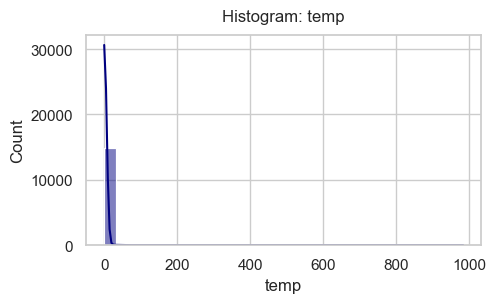

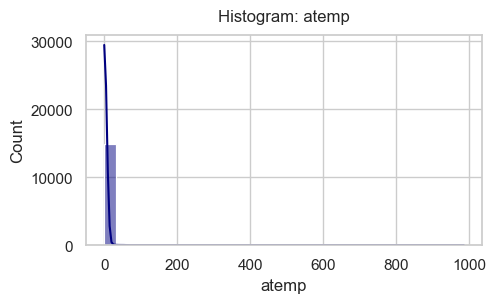

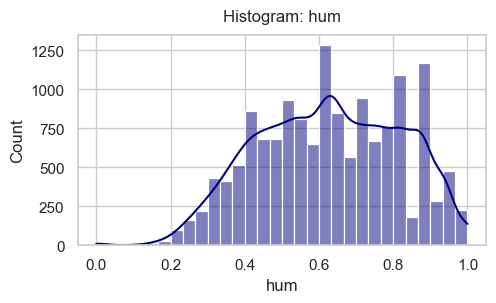

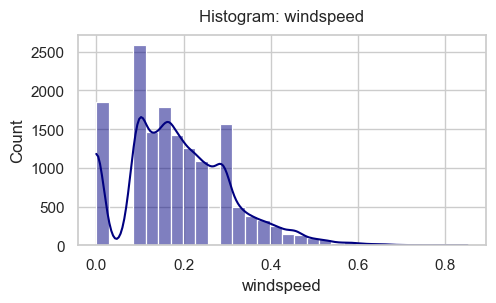

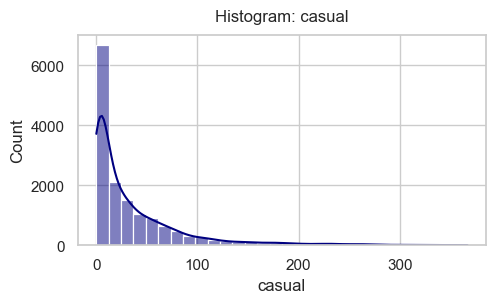

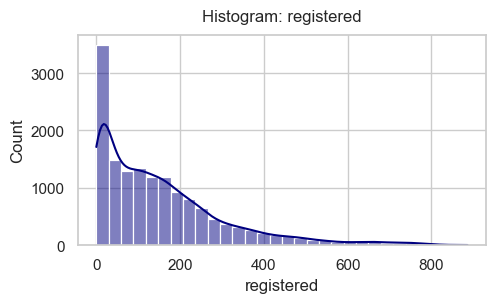

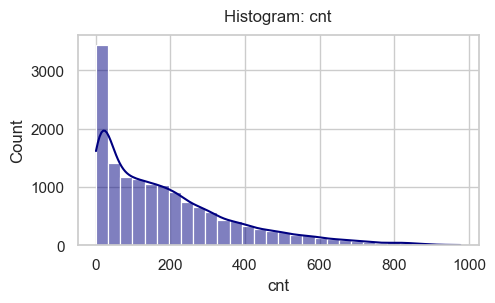

In [260]:
# Histogram and KDE plots for numerical columns
plot_histograms(df, num_cols, color="navy", bins=30, kde = True)

array([[<Axes: title={'center': 'temp | skew=17.19, kurt=311.93'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>,
        <Axes: title={'center': 'atemp | skew=16.80, kurt=301.60'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>,
        <Axes: title={'center': 'hum | skew=-0.12, kurt=-0.76'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>],
       [<Axes: title={'center': 'windspeed | skew=0.62, kurt=0.75'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>,
        <Axes: title={'center': 'casual | skew=2.54, kurt=7.92'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>,
        <Axes: title={'center': 'registered | skew=1.55, kurt=2.71'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>],
       [<Axes: title={'center': 'cnt | skew=1.28, kurt=1.40'}, xlabel='Theoretical quantiles', ylabel='Sample quantiles'>,
        <Axes: >, <Axes: >]], dtype=object)

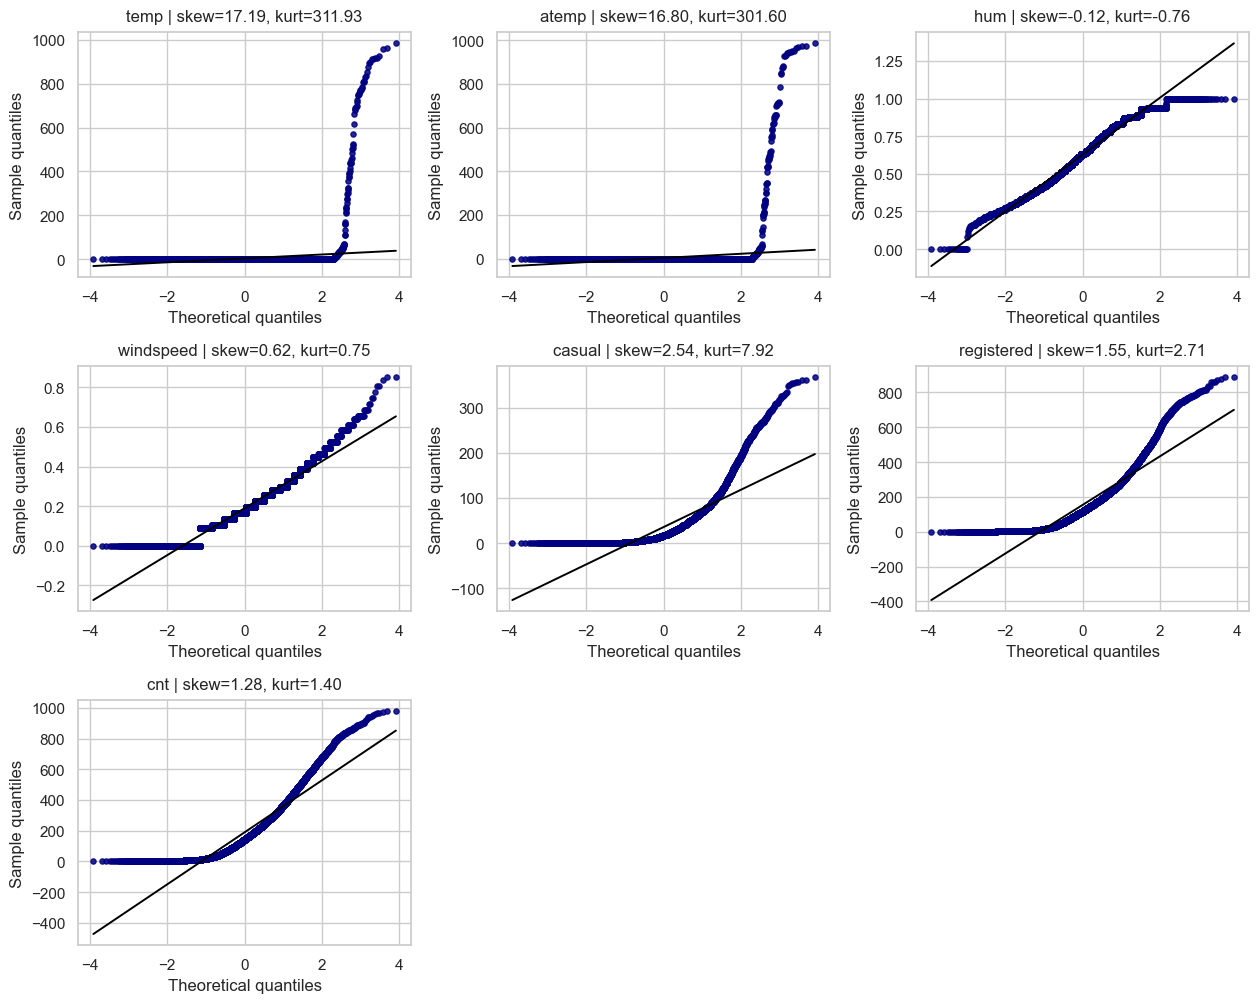

In [261]:
# QQ plots for numerical columns
qq_plots(df, num_cols, dist="norm", sparams=None, ncols=3, height=3.4)

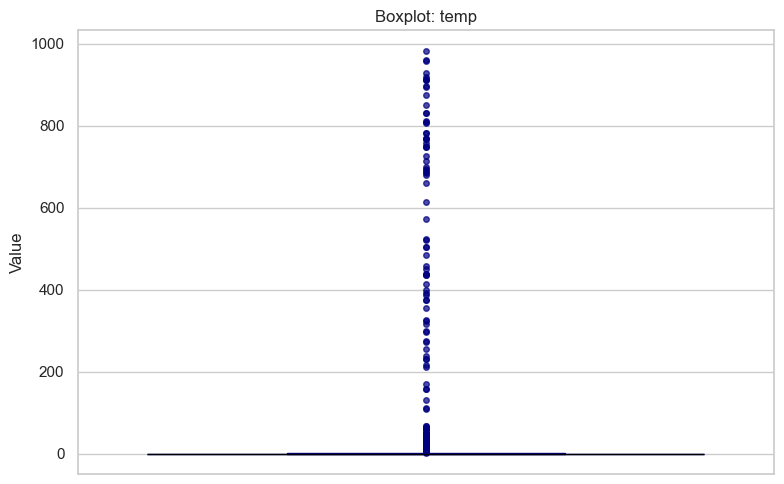

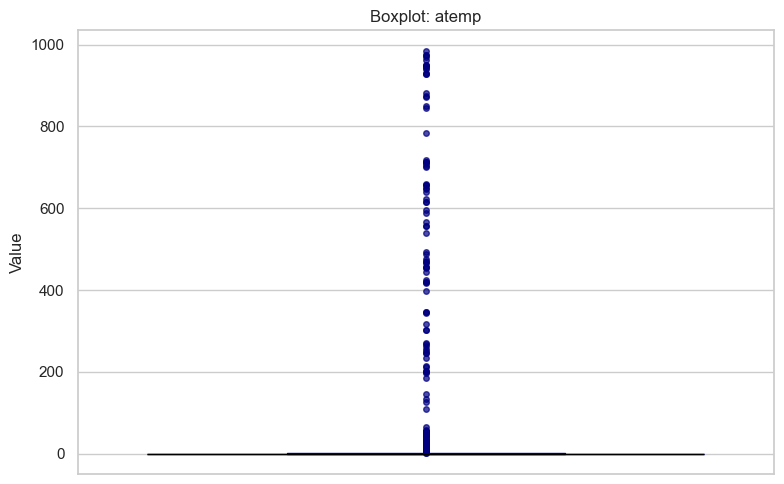

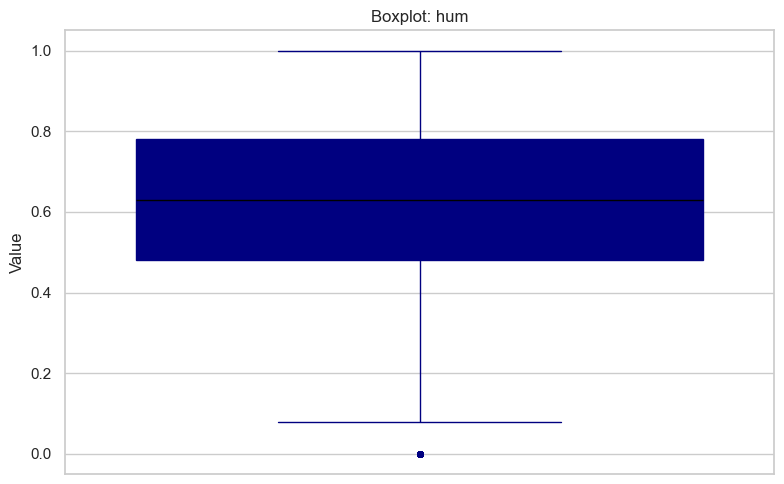

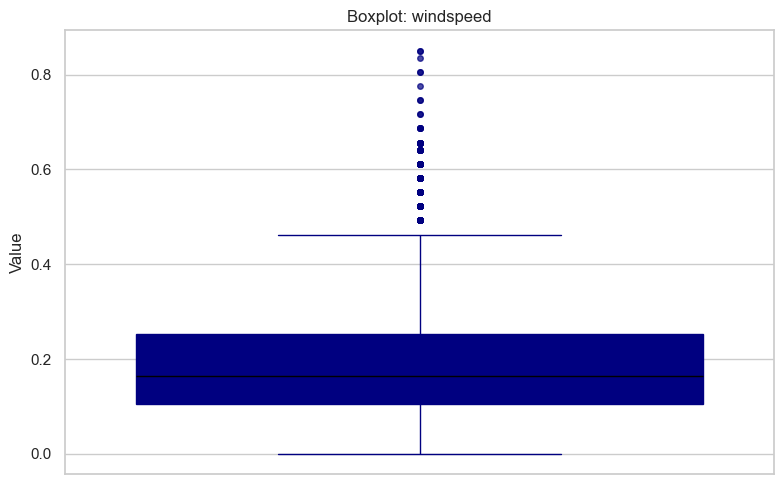

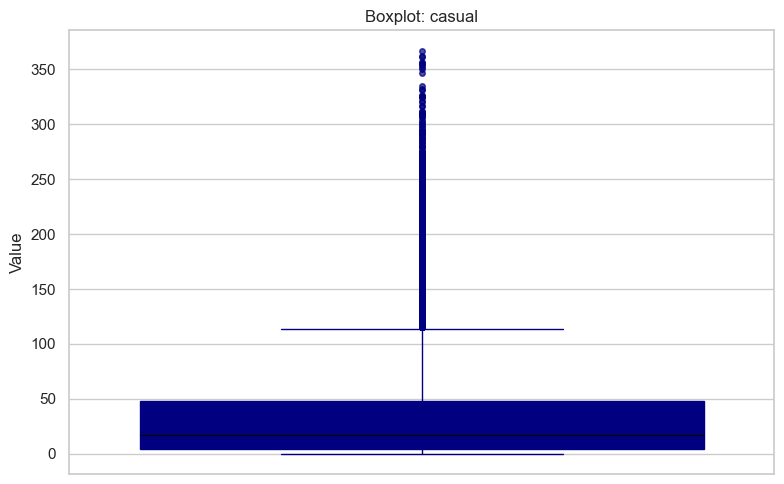

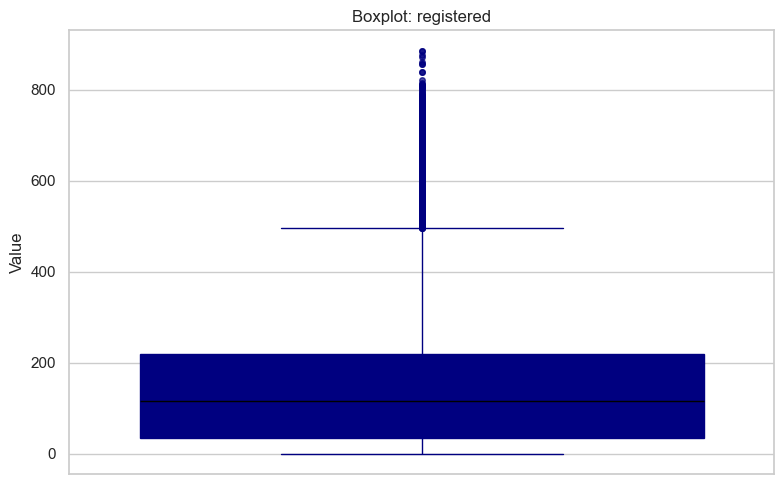

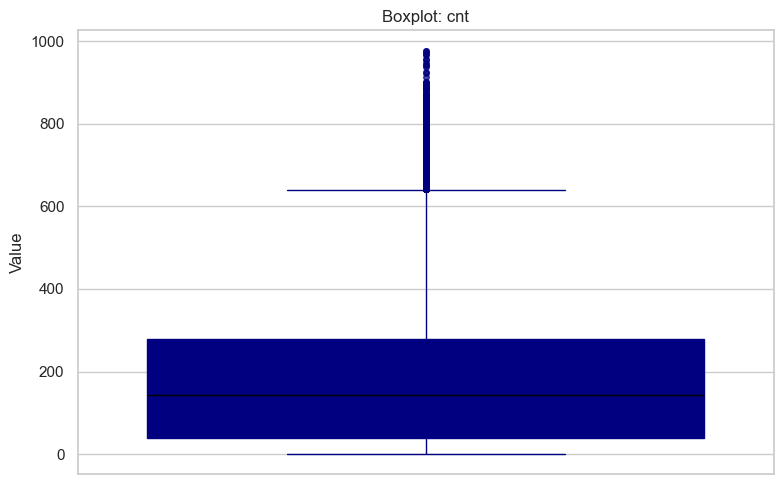

In [262]:
# Box plots for numerical columns
boxplots(df, color="navy")

### Univariate Analysis for Categorical Columns 

In [263]:
# Estadisticas descriptivas para columnas categoricas
display(df[cat_cols].describe(include="category").T)

,count,unique,top,freq
season,15033.0,4.0,3.0,3873.0
yr,15033.0,2.0,1.0,7554.0
mnth,15033.0,12.0,3.0,1302.0
hr,15033.0,24.0,14.0,648.0
holiday,15033.0,2.0,0.0,14597.0
weekday,15033.0,7.0,6.0,2165.0
workingday,15033.0,2.0,1.0,10275.0
weathersit,15033.0,4.0,1.0,10016.0


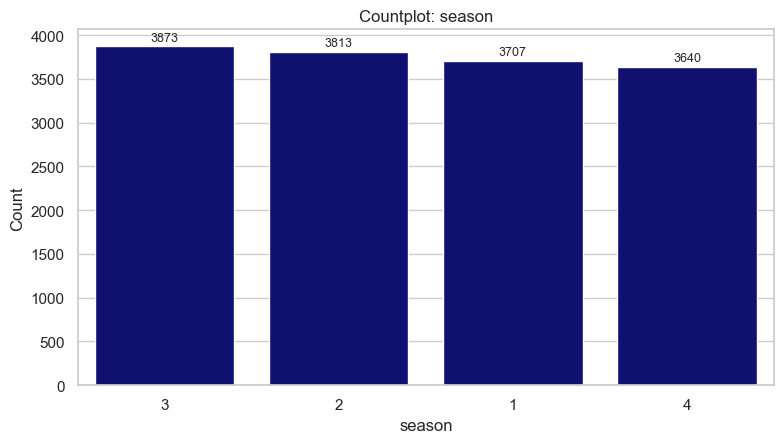

,count,percent
season,,
3,3873,25.76
2,3813,25.36
1,3707,24.66
4,3640,24.21


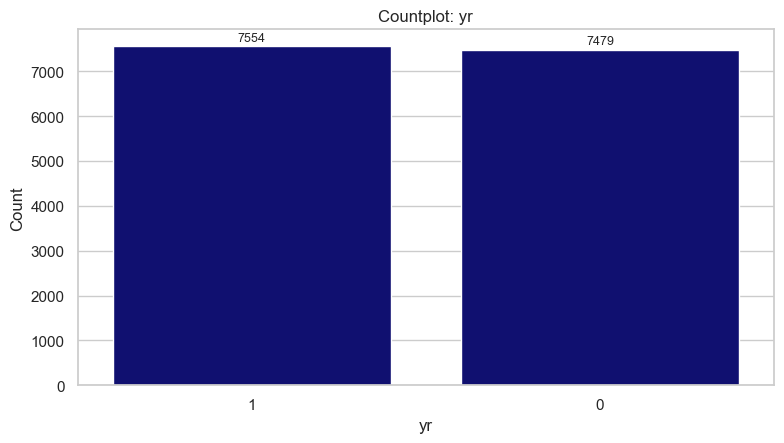

,count,percent
yr,,
1,7554,50.25
0,7479,49.75


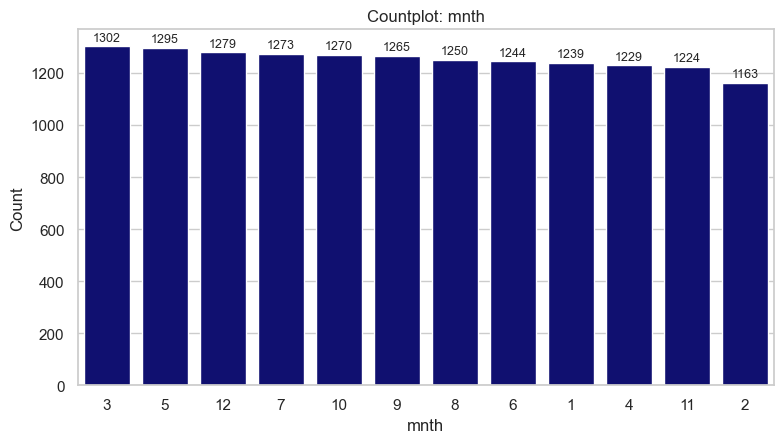

,count,percent
mnth,,
3,1302,8.66
5,1295,8.61
12,1279,8.51
7,1273,8.47
10,1270,8.45
9,1265,8.41
8,1250,8.32
6,1244,8.28
1,1239,8.24


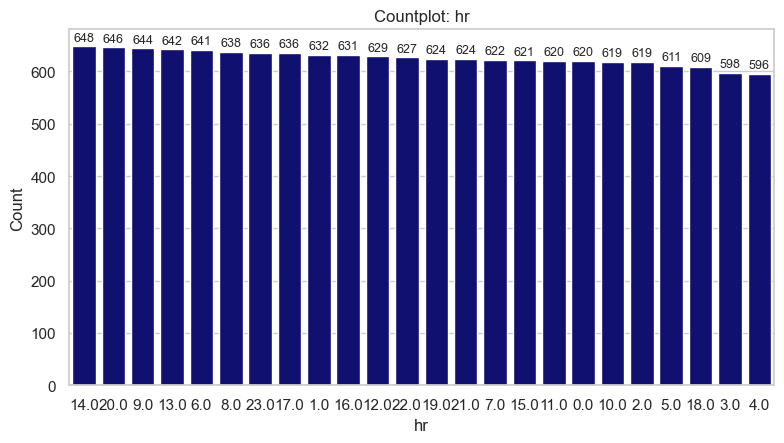

,count,percent
hr,,
14.0,648,4.31
20.0,646,4.30
9.0,644,4.28
13.0,642,4.27
6.0,641,4.26
8.0,638,4.24
23.0,636,4.23
17.0,636,4.23
1.0,632,4.20


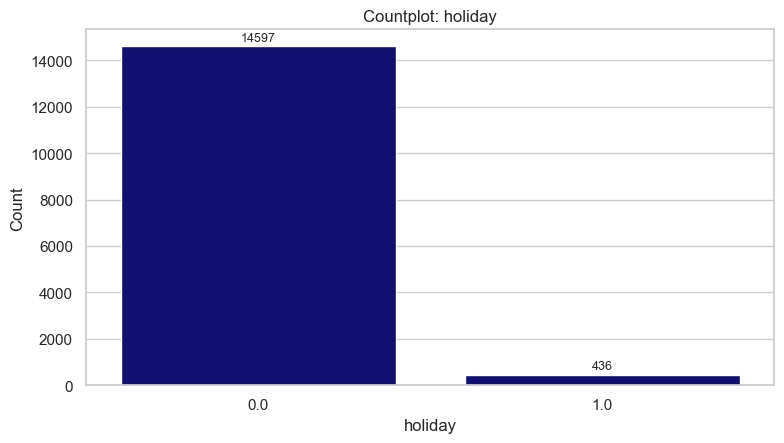

,count,percent
holiday,,
0.0,14597,97.1
1.0,436,2.9


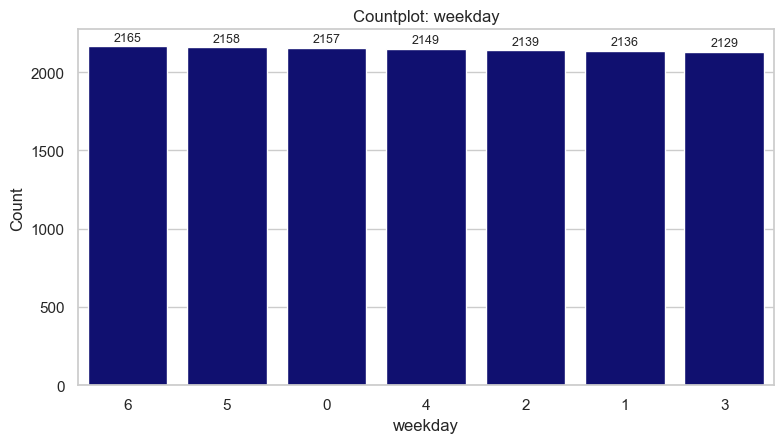

,count,percent
weekday,,
6,2165,14.40
5,2158,14.36
0,2157,14.35
4,2149,14.30
2,2139,14.23
1,2136,14.21
3,2129,14.16


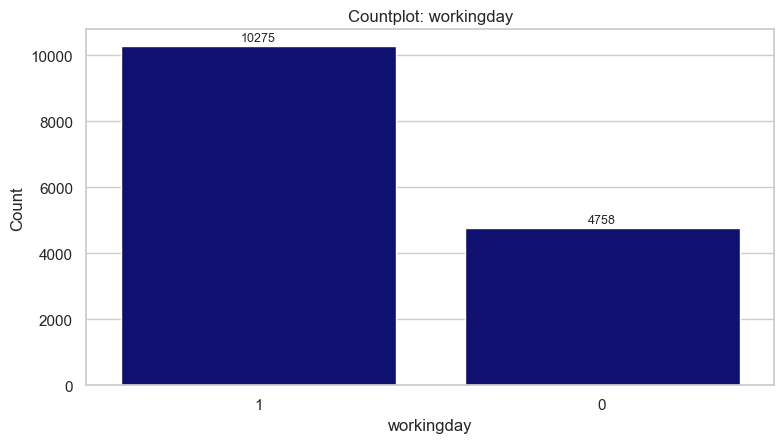

,count,percent
workingday,,
1,10275,68.35
0,4758,31.65


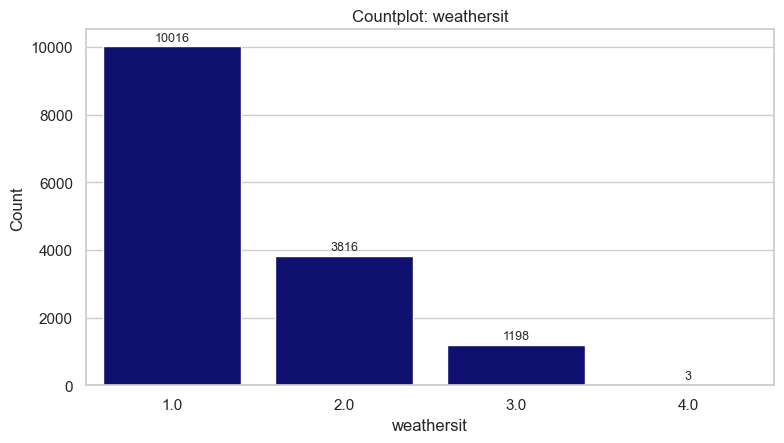

,count,percent
weathersit,,
1.0,10016,66.63
2.0,3816,25.38
3.0,1198,7.97
4.0,3,0.02


In [264]:
# Ver las countplots para las columnas categoricas
simple_countplots(df, columns=cat_cols)

### Bivariate Analysis for Numerical Columns

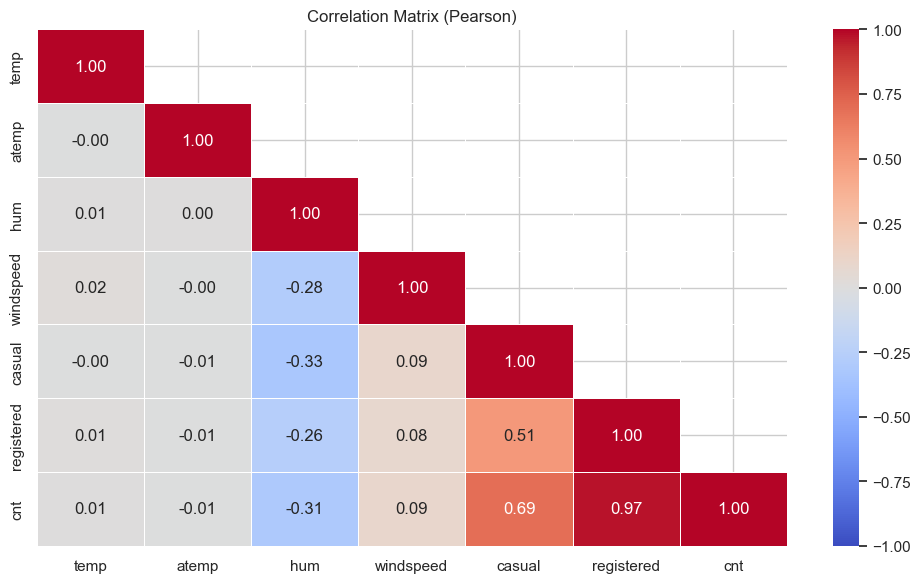

In [265]:
# Matriz de correlacion para columnas numericas
corr = correlation_heatmap(df, columns=num_cols, method="pearson")

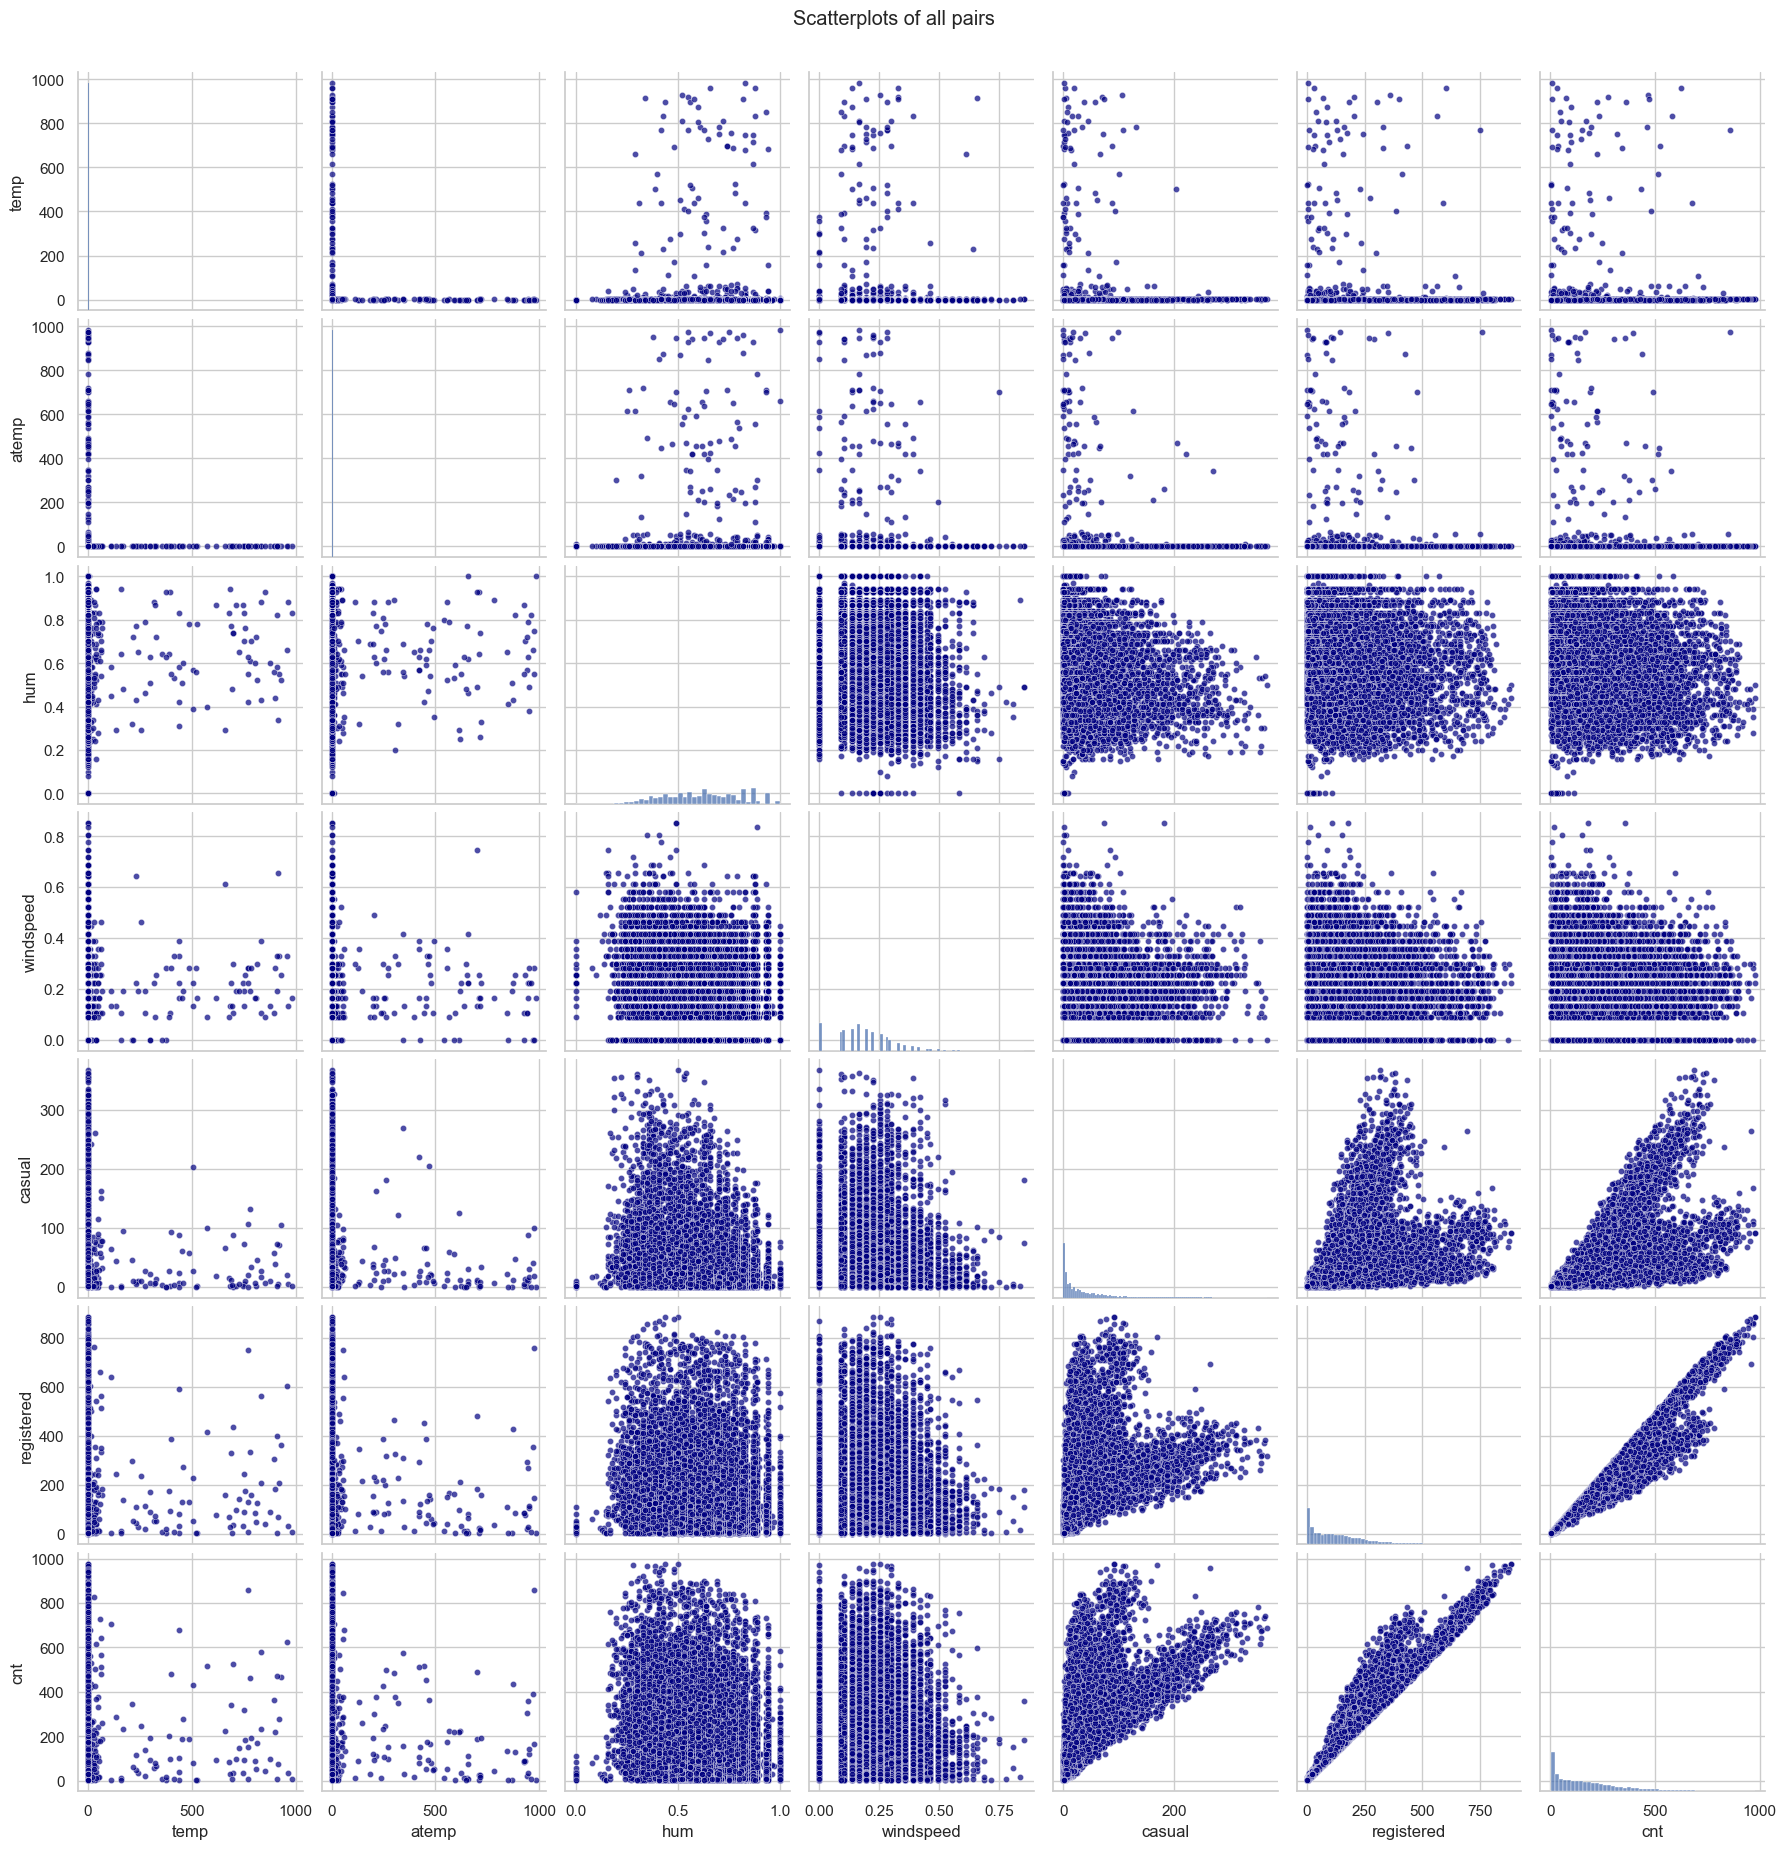

In [266]:
# Scatter matrix para columnas numericas 
scatter_all_pairs(df)

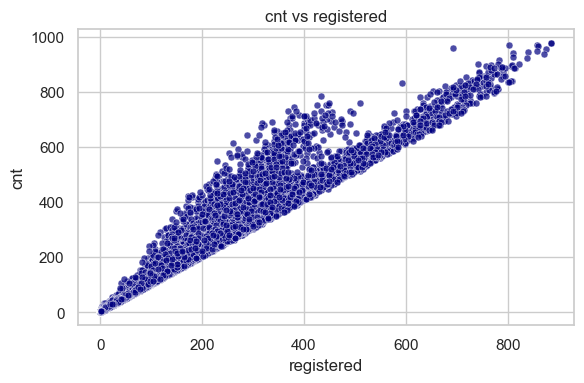

In [267]:
# Scatter plot simple entre dos variables numericas
scatter_simple(df, "registered", "cnt")

### Bivariate Analysis for Categorical Columns

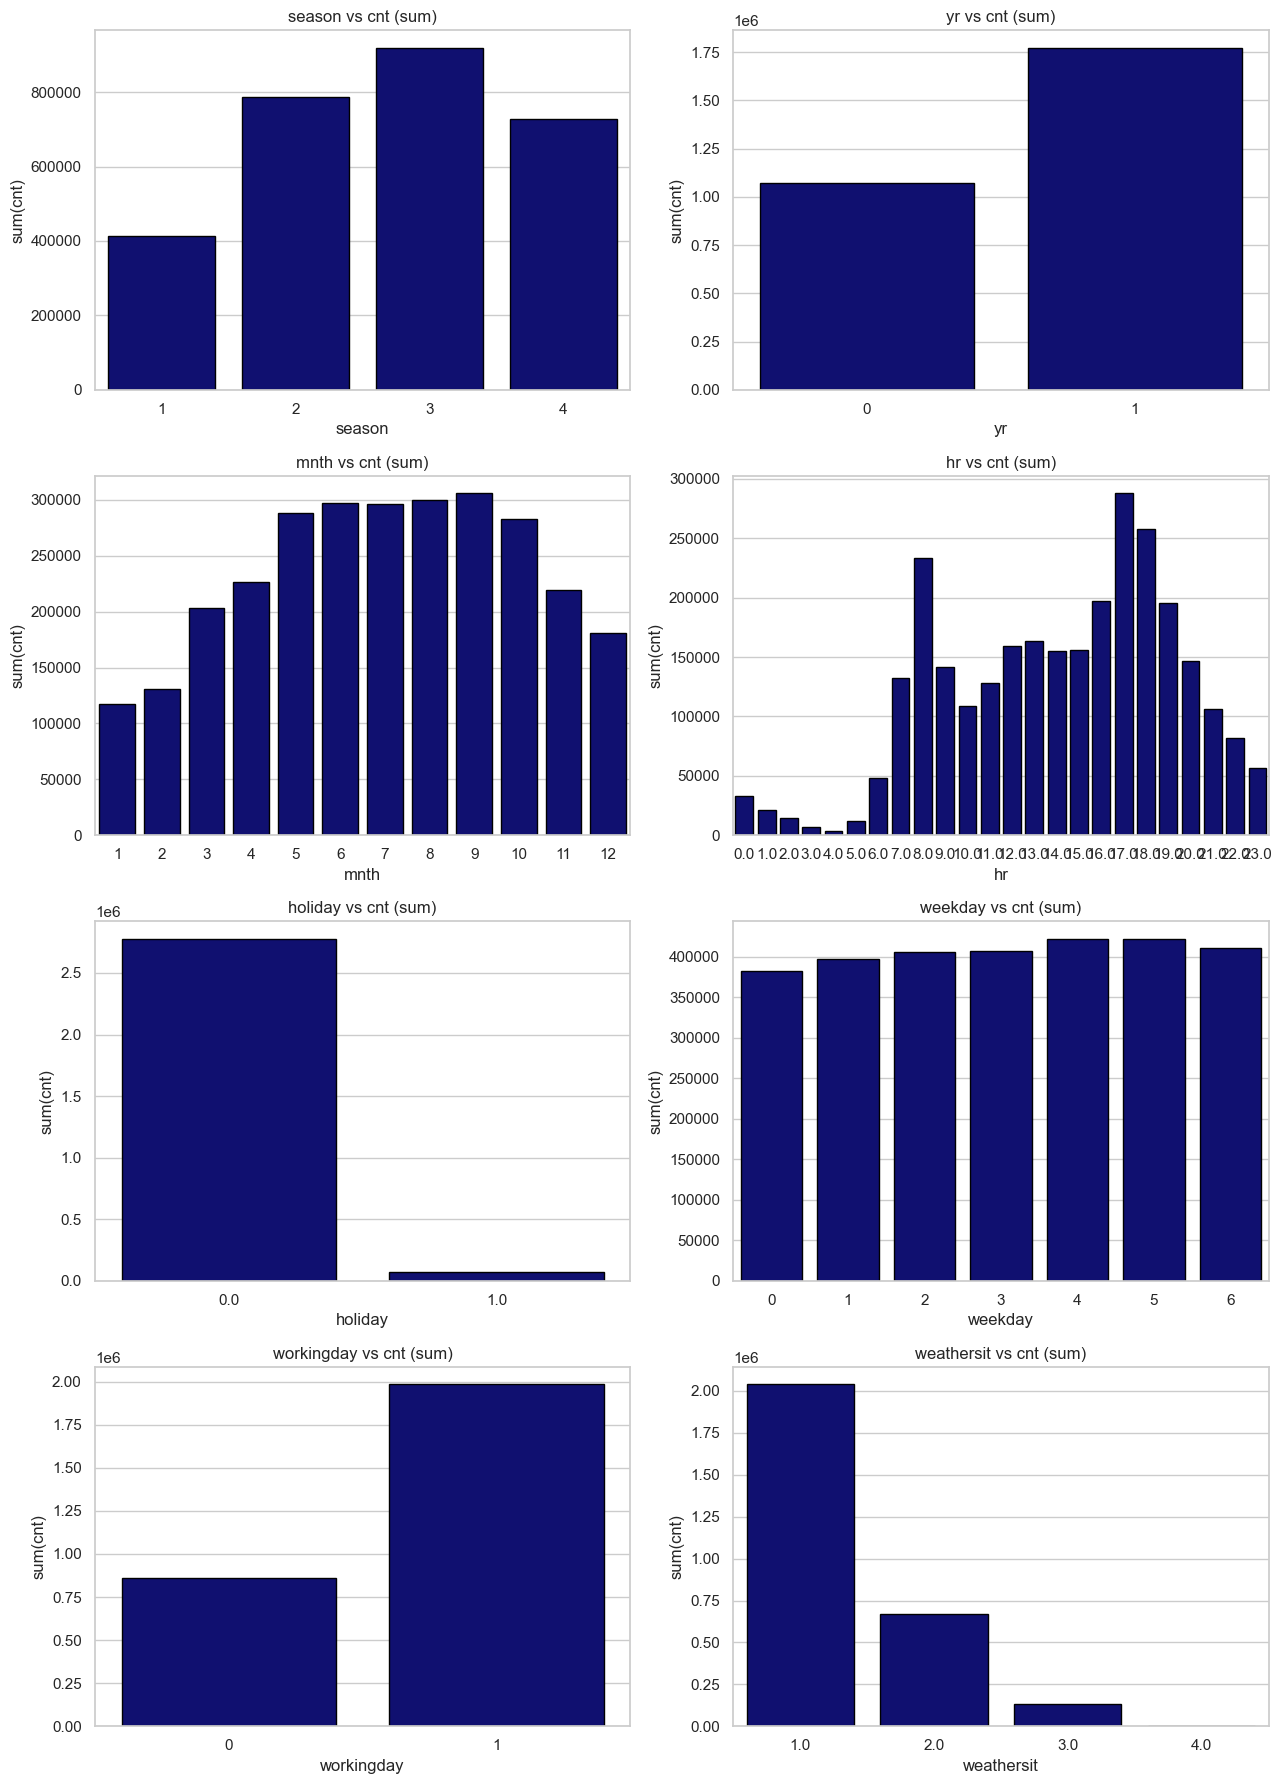

In [268]:
columns= [c for c in cat_cols if c != "cnt"] # columnas categoricas a graficar
barplots(df, x_cols=columns, y="cnt", estimator=sum)


In [269]:
cat_cols

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

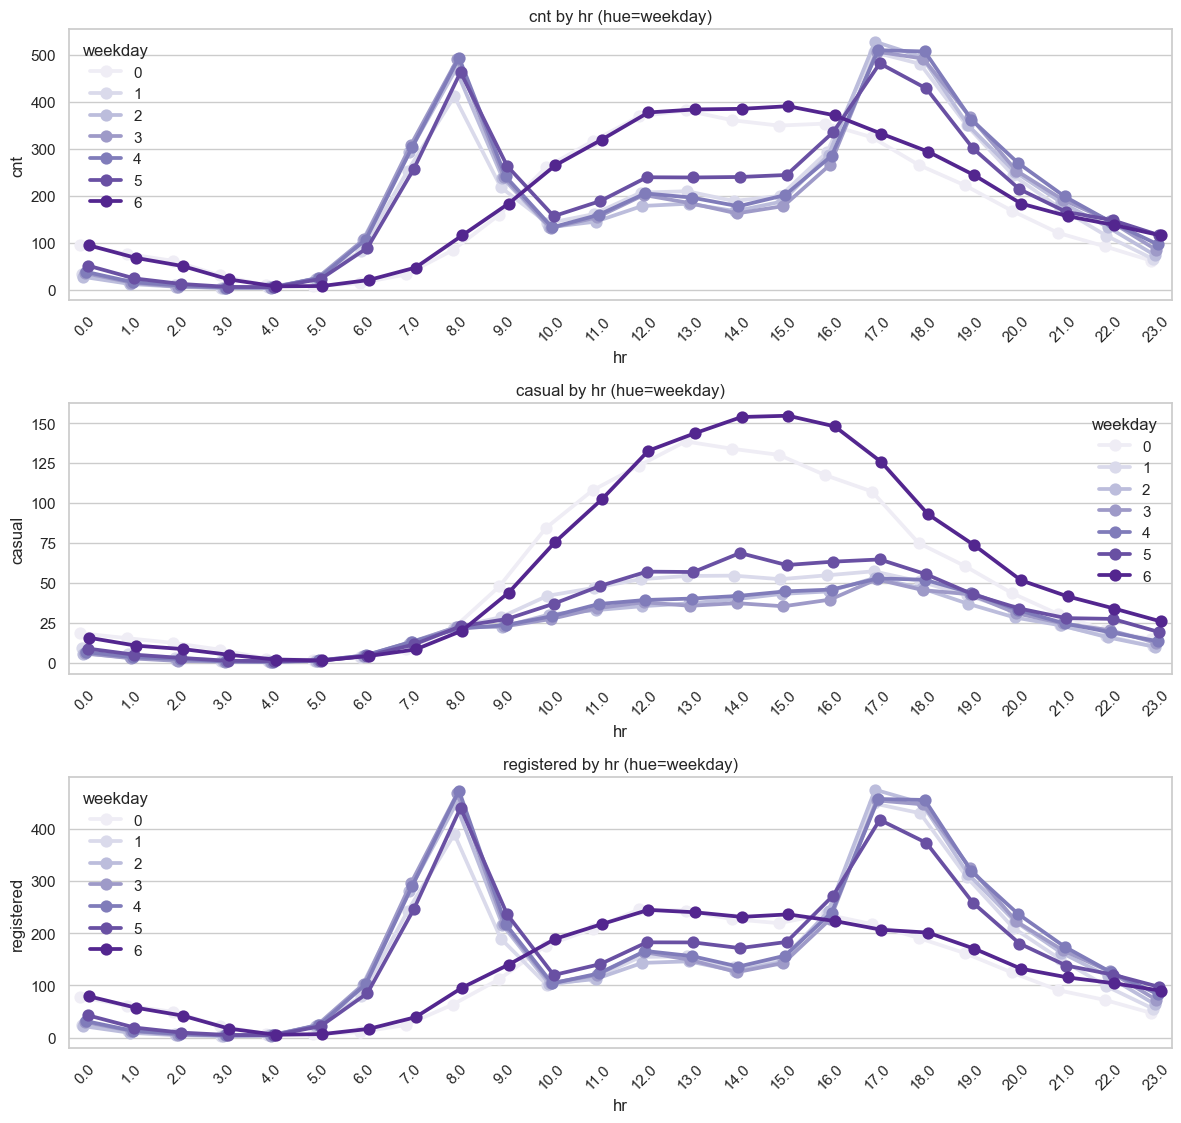

In [270]:
columns =['count', 'casual', 'registered']  # columnas numericas a graficar

pointplots_by_x_for_targets(
    df=df,
    x="hr",
    y_cols=["cnt", "casual", "registered"],
    hue="weekday",
    err="none",          
    ncols=1,             
    height=3.8
)

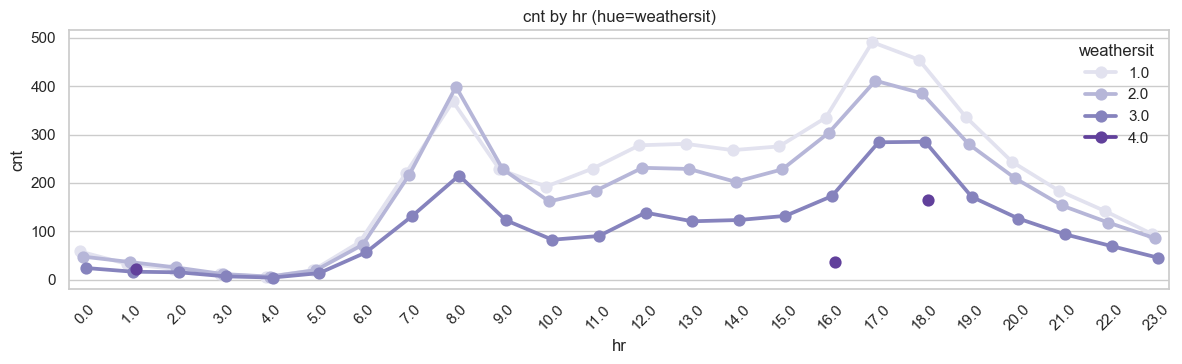

In [271]:
pointplots_by_x_for_targets(
    df=df,
    x="hr",
    y_cols=["cnt"],
    hue="weathersit",
    err="none",          
    ncols=1,             
    height=3.8
)

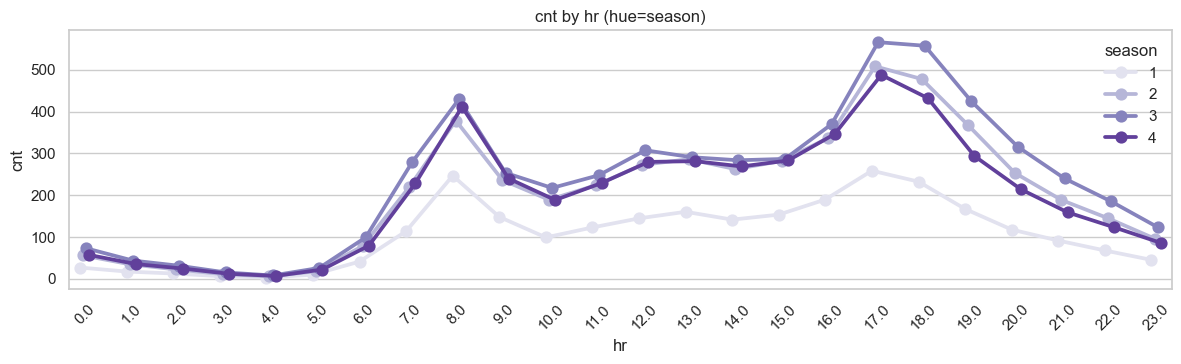

In [272]:
pointplots_by_x_for_targets(
    df=df,
    x="hr",
    y_cols=["cnt"],
    hue="season",
    err="none",          
    ncols=1,             
    height=3.8
)

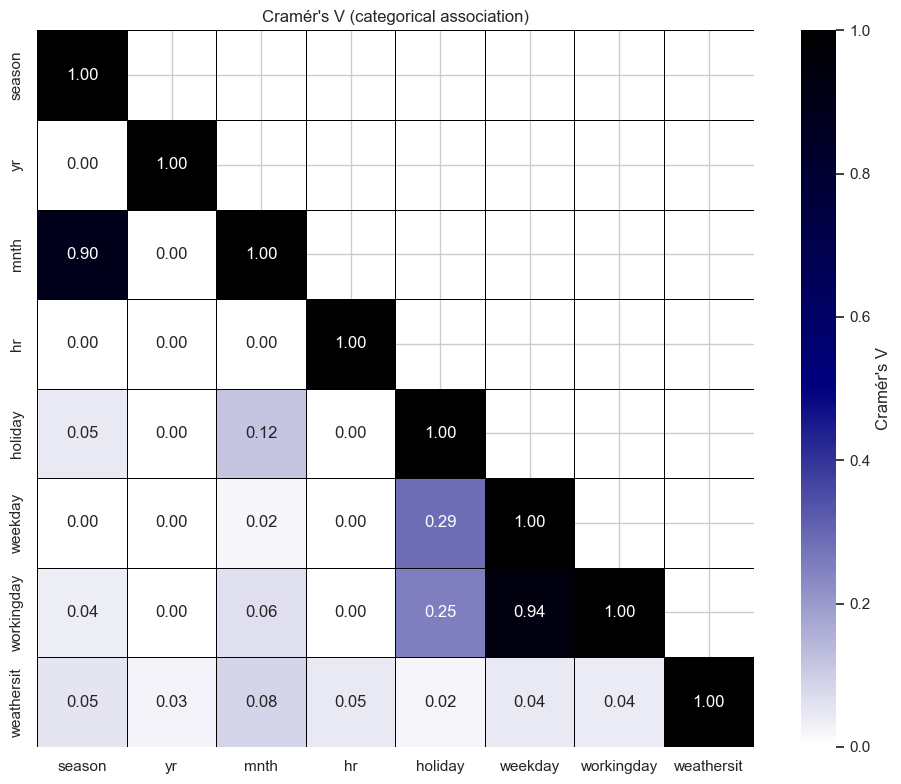

In [273]:
# Heatmap de la correlacion categorica
cramers_v_heatmap = cramers_v_heatmap(df, columns=cat_cols, bias_correction=True, mask_upper=True, annot=True)